# 1. Data Prep

In [9]:
import zipfile
from pathlib import Path

In [10]:
data_path = Path("data/")
zip_path = Path("/content/pizza_steak_sushi.zip")
image_path = data_path / "pizza_steak_sushi_images"

In [11]:
if image_path.is_dir():
  print(f"{image_path} already exists")
else:
  print(f"Creating {image_path} and extracting data")
  image_path.mkdir(parents=True, exist_ok=True)

  with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(image_path)

  print("Unzipped --")

Creating data/pizza_steak_sushi_images and extracting data
Unzipped --


In [12]:
print(list(image_path.iterdir()))

[PosixPath('data/pizza_steak_sushi_images/test'), PosixPath('data/pizza_steak_sushi_images/train')]


In [13]:
import os

print("Structure of our dataset: ")

for dirpath, dirnames, filenames in os.walk(image_path):

  # print(dirpath)
  # print(dirnames)
  # print(filenames)

  num_dirs = len(dirnames)
  num_files = len(filenames)

  rel_path = os.path.relpath(dirpath, data_path)
  print(f"{rel_path}/")
  print(f"   ├── {num_dirs} subfolder(s)")
  print(f"   └── {num_files} file(s)\n")

Structure of our dataset: 
pizza_steak_sushi_images/
   ├── 2 subfolder(s)
   └── 0 file(s)

pizza_steak_sushi_images/test/
   ├── 3 subfolder(s)
   └── 0 file(s)

pizza_steak_sushi_images/test/pizza/
   ├── 0 subfolder(s)
   └── 25 file(s)

pizza_steak_sushi_images/test/steak/
   ├── 0 subfolder(s)
   └── 19 file(s)

pizza_steak_sushi_images/test/sushi/
   ├── 0 subfolder(s)
   └── 31 file(s)

pizza_steak_sushi_images/train/
   ├── 3 subfolder(s)
   └── 0 file(s)

pizza_steak_sushi_images/train/pizza/
   ├── 0 subfolder(s)
   └── 78 file(s)

pizza_steak_sushi_images/train/steak/
   ├── 0 subfolder(s)
   └── 75 file(s)

pizza_steak_sushi_images/train/sushi/
   ├── 0 subfolder(s)
   └── 72 file(s)



In [14]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_images/train'),
 PosixPath('data/pizza_steak_sushi_images/test'))

# 2. Create Datasets and DataLoaders

## 2.1 manual transform

In [15]:
from torchvision import transforms

In [16]:
manual_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [17]:
from torchvision import datasets
from torch.utils.data import DataLoader

In [18]:
import os

NUM_WORKERS = os.cpu_count()

In [19]:
def create_dataloaders(train_dir: str, test_dir: str, transform: transforms.Compose, batch_size: int=32, num_workers: int=NUM_WORKERS):
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  class_names = train_data.classes

  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
  test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

  return train_dataloader, test_dataloader, class_names, train_data, test_data

In [20]:
train_dataloader, test_dataloader, class_names, train_data, test_data = create_dataloaders(train_dir, test_dir, transform=manual_transforms)

In [21]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi_images/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [22]:
train_dataloader

In [23]:
imgs, labels = next(iter(train_dataloader))

print(len(labels), len(imgs))

32 32


In [24]:
class_names

['pizza', 'steak', 'sushi']

## 2.2 auto transform

In [25]:
import torchvision

In [26]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

In [27]:
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [28]:
weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [29]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [30]:
train_dataloader, test_dataloader, class_names, train_data, test_data = create_dataloaders(train_dir, test_dir, transform=auto_transforms)

In [31]:
train_data.transforms

StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )

# 3. Getting a pretrained model

In [32]:
import torch

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [34]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 147MB/s]


In [35]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [36]:
!pip install torchinfo

In [38]:
from torchinfo import summary

In [42]:
next(iter(train_dataloader))[0][0].shape

torch.Size([3, 224, 224])

In [43]:
summary(model, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [46]:
for param in model.features.parameters():
  param.requires_grad = False

In [48]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True)
).to(device)

In [49]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [51]:
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 3]                   --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          (6,004)
│    │    └─MBConv: 3-6                      

# 4. Train model

In [53]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_fn = torch.optim.Adam(model.parameters(), lr=0.001)

In [57]:
import torch
from tqdm.auto import tqdm
import torch.multiprocessing

In [58]:
try:
  torch.multiprocessing.set_start_method("spawn", force=True)
except RuntimeError:
  pass

In [59]:
def train(model, train_dataloader, test_dataloader, optimizer_fn, loss_fn, epochs: int = 5, device: str = "cuda", verbose: bool = True):

  model.to(device)

  history = {
      "train_loss": [],
      "train_acc": [],
      "val_loss": [],
      "val_acc": []
  }

  for epoch in range(1, epochs + 1):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for X, y in tqdm(train_dataloader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False):
      X, y = X.to(device), y.to(device)

      optimizer_fn.zero_grad()
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      loss.backward()
      optimizer_fn.step()

      train_loss += loss.item() * X.size(0)
      _, preds = torch.max(y_pred, 1)
      train_correct += (preds == y).sum().item()
      train_total += y.size(0)

    avg_train_loss = train_loss / train_total
    train_acc = train_correct / train_total

    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    with torch.no_grad():
      for X, y in tqdm(test_dataloader, desc=f"Epoch {epoch}/{epochs} [Eval]", leave=False):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        test_loss += loss.item() * X.size(0)
        _, preds = torch.max(y_pred, 1)
        test_correct += (preds == y).sum().item()
        test_total += y.size(0)

    avg_test_loss = test_loss / test_total
    test_acc = test_correct / test_total

    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(avg_test_loss)
    history["val_acc"].append(test_acc)

    if verbose:
      print(f"Epoch [{epoch}/{epochs}] "
            f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Val Loss: {avg_test_loss:.4f} | Val Acc: {test_acc:.4f}")

  print("Training complete")
  return history

In [60]:
history = train(
  model=model,
  train_dataloader=train_dataloader,
  test_dataloader=test_dataloader,
  optimizer_fn=optimizer_fn,
  loss_fn=loss_fn,
  epochs=5,
  device=device
)

Epoch 1/5 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/5 [Eval]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch [1/5] Train Loss: 0.5447 | Train Acc: 0.8222 | Val Loss: 0.5412 | Val Acc: 0.8667


Epoch 2/5 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/5 [Eval]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch [2/5] Train Loss: 0.5110 | Train Acc: 0.8800 | Val Loss: 0.5331 | Val Acc: 0.8933


Epoch 3/5 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/5 [Eval]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch [3/5] Train Loss: 0.4408 | Train Acc: 0.9200 | Val Loss: 0.4906 | Val Acc: 0.9067


Epoch 4/5 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/5 [Eval]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch [4/5] Train Loss: 0.4074 | Train Acc: 0.9422 | Val Loss: 0.4852 | Val Acc: 0.8667


Epoch 5/5 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/5 [Eval]:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch [5/5] Train Loss: 0.3883 | Train Acc: 0.9289 | Val Loss: 0.4464 | Val Acc: 0.8800
Training complete


In [61]:
history

{'train_loss': [0.5446626928117541,
  0.5109742546081543,
  0.4407708178626166,
  0.407410954369439,
  0.3882735957039727],
 'train_acc': [0.8222222222222222,
  0.88,
  0.92,
  0.9422222222222222,
  0.9288888888888889],
 'val_loss': [0.5412005400657653,
  0.5330946580568949,
  0.49059083620707195,
  0.4852360781033834,
  0.44636673013369244],
 'val_acc': [0.8666666666666667,
  0.8933333333333333,
  0.9066666666666666,
  0.8666666666666667,
  0.88]}

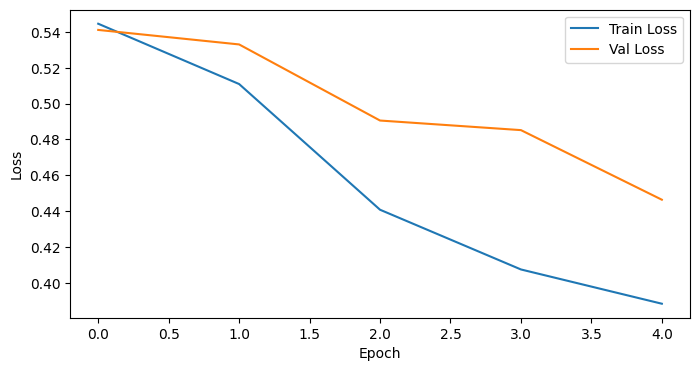

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 5. Visualize predictions

In [63]:
import matplotlib.pyplot as plt
import torch
import random

In [64]:
def vis_preds(model, dataloader, class_names, device="cuda", num_images=16):
  model.eval()
  model.to(device)

  X_batch, y_batch = next(iter(dataloader))
  X_batch, y_batch = X_batch.to(device), y_batch.to(device)

  idx = random.sample(range(len(X_batch)), num_images)

  X_sample = X_batch[idx]
  y_true = y_batch[idx]
  print(f"X_sample.shape: {X_sample.shape}; y_sample.shape: {y_batch.shape}")

  print()

  with torch.no_grad():
    y_pred = model(X_sample)

  y_pred_classes = y_pred.argmax(dim=1)

  X_sample = X_sample.cpu()
  X_sample = X_sample * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
  X_sample = X_sample + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
  X_sample = torch.clamp(X_sample, 0, 1)

  plt.figure(figsize=(10, 10))
  for i in range(num_images):
    ax = plt.subplot(4, 4, i + 1)
    img = X_sample[i].permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)

    true_label = class_names[y_true[i]]
    pred_label = class_names[y_pred_classes[i]]
    color = "green" if y_true[i] == y_pred_classes[i] else "red"
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color, fontsize=9)
    plt.axis("off")

  plt.tight_layout()
  plt.show()

X_sample.shape: torch.Size([16, 3, 224, 224]); y_sample.shape: torch.Size([32])



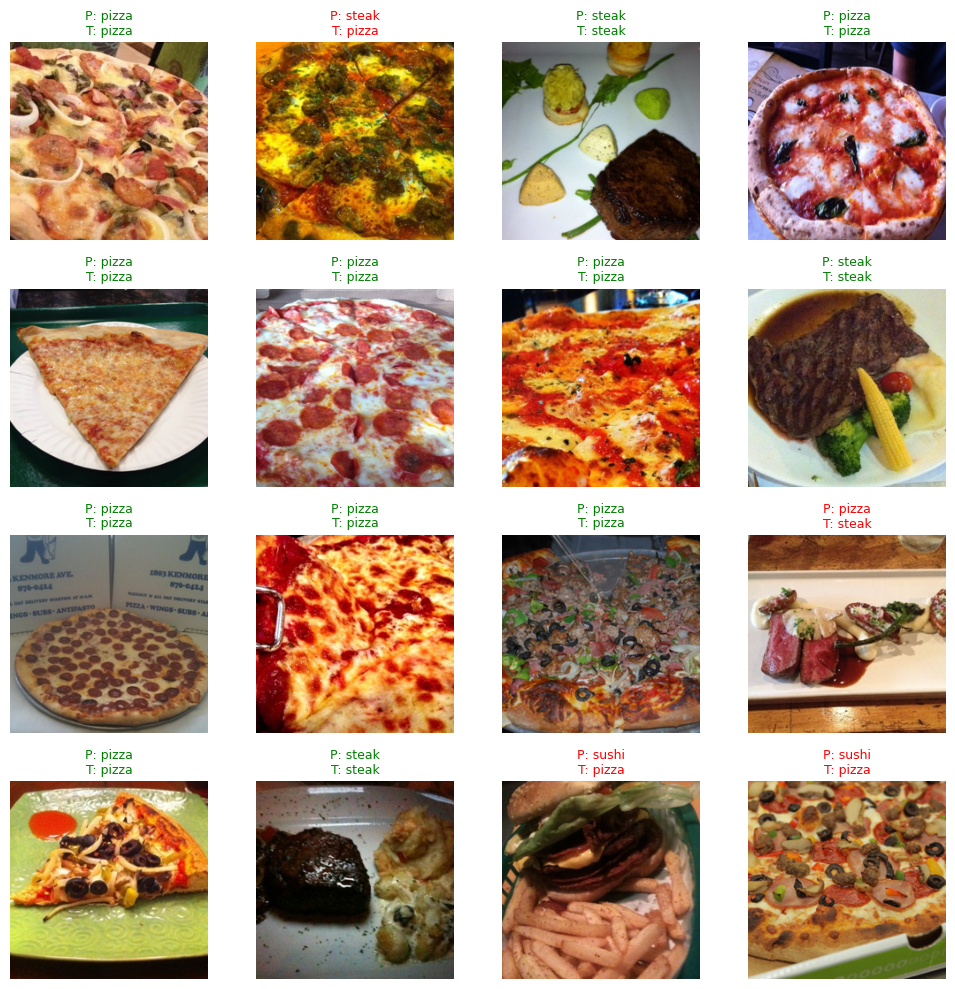

In [65]:
vis_preds(model, test_dataloader, class_names)

In [66]:
def vis_preds_side_by_side(model, dataloader, class_names, device="cuda", num_images=5):
  model.eval()
  model.to(device)

  X_batch, y_batch = next(iter(dataloader))
  X_batch, y_batch = X_batch.to(device), y_batch.to(device)

  idxs = random.sample(range(len(X_batch)), num_images)
  X_sample, y_true = X_batch[idxs], y_batch[idxs]

  with torch.no_grad():
    y_pred = model(X_sample)
  y_pred_classes = y_pred.argmax(dim=1)

  X_sample = X_sample.cpu()
  X_sample = X_sample * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
  X_sample = X_sample + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
  X_sample = torch.clamp(X_sample, 0, 1)

  plt.figure(figsize=(6, num_images * 3))
  for i in range(num_images):
    ax1 = plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(X_sample[i].permute(1, 2, 0))
    true_label = class_names[y_true[i]]
    plt.title(f"Actual: {true_label}", color="black", fontsize=10)
    plt.axis("off")

    ax2 = plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(X_sample[i].permute(1, 2, 0))
    pred_label = class_names[y_pred_classes[i]]
    color = "green" if y_true[i] == y_pred_classes[i] else "red"
    plt.title(f"Pred: {pred_label}", color=color, fontsize=10)
    plt.axis("off")

  plt.tight_layout()
  plt.show()

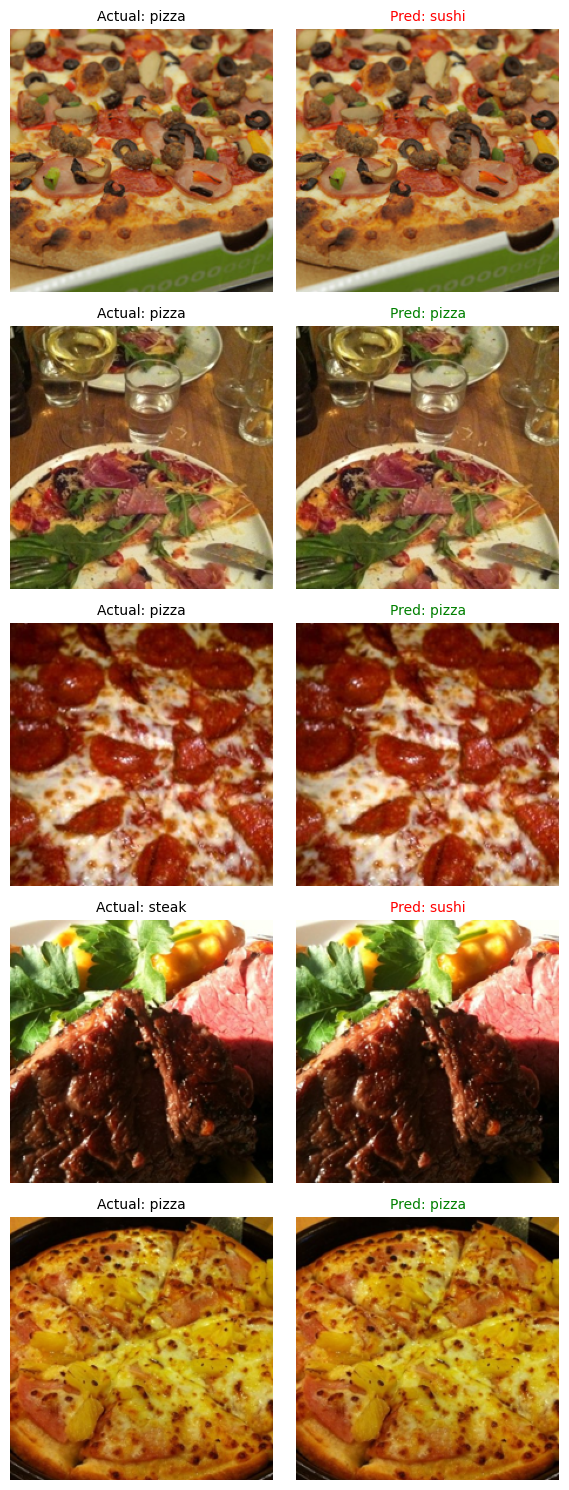

In [69]:
vis_preds_side_by_side(model, test_dataloader, class_names, device=device, num_images=5)

## 5.1 Predictions on custom data

In [70]:
import torch
from PIL import Image
from torchvision import transforms
import requests
from io import BytesIO
import matplotlib.pyplot as plt

In [75]:
def predict_image(model, image_path_or_url, class_names, device="cuda", transform=None):
  model.eval()
  model.to(device)

  if image_path_or_url.startswith("http"):
    response = requests.get(image_path_or_url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
  else:
    img = Image.open(image_path_or_url).convert("RGB")

  if transform is None:
    from torchvision.models import EfficientNet_B0_Weights
    transform = EfficientNet_B0_Weights.DEFAULT.transforms()

  img_t = transform(img).unsqueeze(0).to(device)

  with torch.no_grad():
    preds = model(img_t)
    probs = torch.softmax(preds, dim=1)
    pred_idx = probs.argmax(dim=1).item()
    confidence = probs[0][pred_idx].item()

  pred_class = class_names[pred_idx]

  plt.imshow(img)
  plt.axis("off")
  plt.title(f"Predicted: {pred_class} ({confidence*100:.1f}%)", fontsize=12)
  plt.show()

  return pred_class, confidence

### 5.1.1. Predictions on steak images

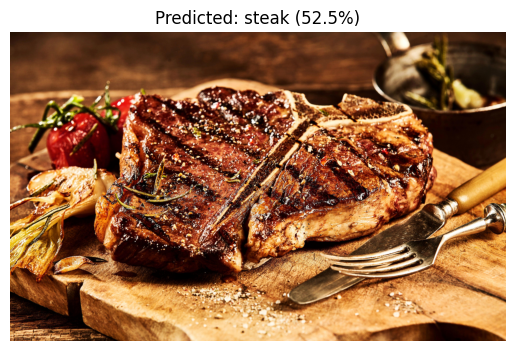

Predicted class: steak (52.51%)


In [76]:
url = "https://wallpaperaccess.com/full/1462828.jpg"

pred_class, confidence = predict_image(model, url, class_names, device=device)
print(f"Predicted class: {pred_class} ({confidence*100:.2f}%)")

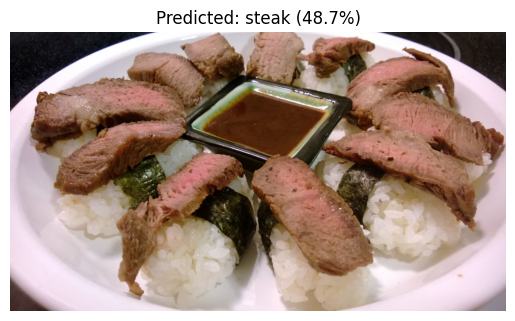

Predicted class: steak (48.73%)


In [77]:
url = "https://i.pinimg.com/originals/13/8b/6e/138b6e57c8a0b4f2991385907156d6e8.jpg"

pred_class, confidence = predict_image(model, url, class_names, device=device)
print(f"Predicted class: {pred_class} ({confidence*100:.2f}%)")

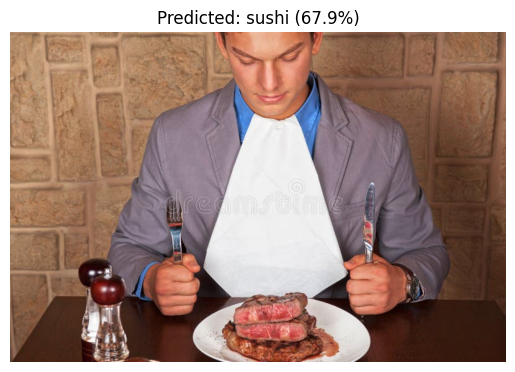

Predicted class: sushi (67.95%)


In [78]:
url = "https://thumbs.dreamstime.com/b/eat-beef-steak-man-holding-knife-fork-ready-to-32293313.jpg"

pred_class, confidence = predict_image(model, url, class_names, device=device)
print(f"Predicted class: {pred_class} ({confidence*100:.2f}%)")

In [82]:
url = "https://img.freepik.com/premium-photo/couple-eating-steak-restaurant-focus-steak-food_579873-15862.jpg"

pred_class, confidence = predict_image(model, url, class_names, device=device)
print(f"Predicted class: {pred_class} ({confidence*100:.2f}%)")

Predicted class: steak (67.64%)


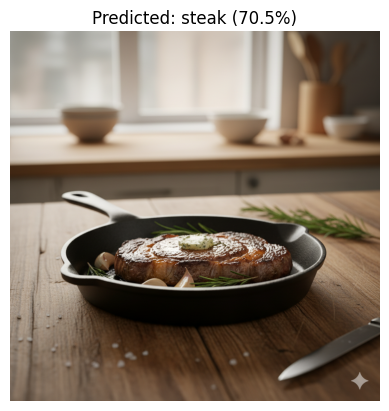

Predicted class: steak (70.52%)


In [87]:
url = "gemini_steak0.png"

pred_class, confidence = predict_image(model, url, class_names, device=device)
print(f"Predicted class: {pred_class} ({confidence*100:.2f}%)")

### 5.1.2 Predictons on sushi images

In [83]:
url = "https://img.freepik.com/free-photo/close-up-person-eating-sushi_23-2151345040.jpg"

pred_class, confidence = predict_image(model, url, class_names, device=device)
print(f"Predicted class: {pred_class} ({confidence*100:.2f}%)")

Predicted class: sushi (89.90%)


In [84]:
url = "https://img.freepik.com/free-photo/close-up-people-eating-sushi_23-2151345005.jpg"

pred_class, confidence = predict_image(model, url, class_names, device=device)
print(f"Predicted class: {pred_class} ({confidence*100:.2f}%)")

Predicted class: sushi (80.29%)


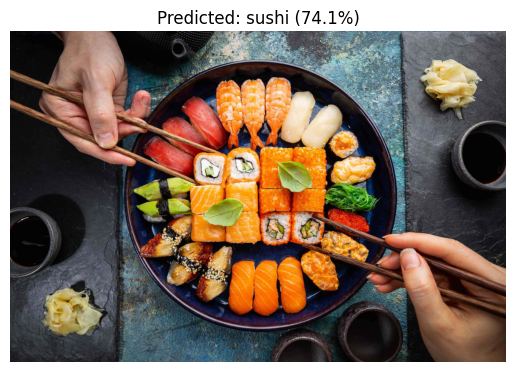

Predicted class: sushi (74.11%)


In [85]:
url = "https://wallpapers.com/images/featured/typer-av-sushi-bilder-2ds76f6haqmjd6ky.jpg"

pred_class, confidence = predict_image(model, url, class_names, device=device)
print(f"Predicted class: {pred_class} ({confidence*100:.2f}%)")

### 5.1.3 Predictions on pizza images

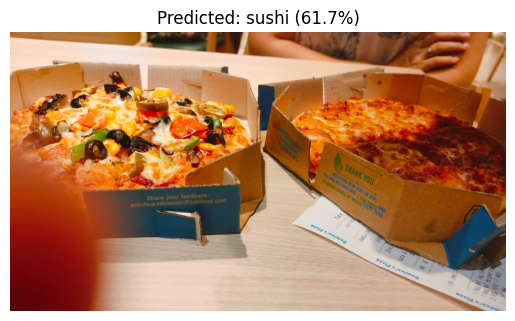

Predicted class: sushi (61.69%)


In [88]:
url = "/content/pizza0.jpg"

pred_class, confidence = predict_image(model, url, class_names, device=device)
print(f"Predicted class: {pred_class} ({confidence*100:.2f}%)")

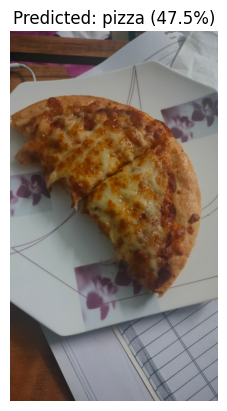

Predicted class: pizza (47.48%)


In [89]:
url = "/content/pizza1.jpg"

pred_class, confidence = predict_image(model, url, class_names, device=device)
print(f"Predicted class: {pred_class} ({confidence*100:.2f}%)")

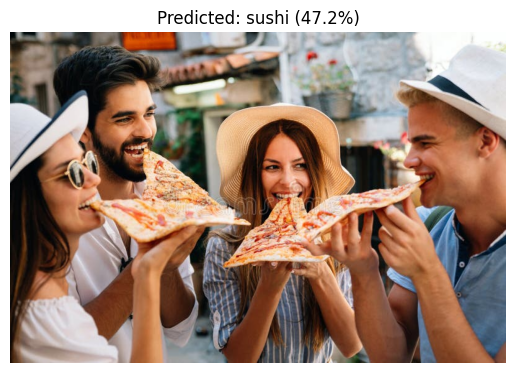

Predicted class: sushi (47.23%)


In [91]:
url = "https://thumbs.dreamstime.com/b/happy-group-people-eating-pizza-outdoors-enjoying-together-193217823.jpg"

pred_class, confidence = predict_image(model, url, class_names, device=device)
print(f"Predicted class: {pred_class} ({confidence*100:.2f}%)")

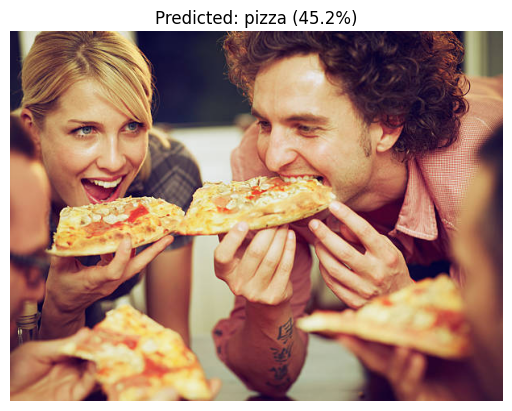

Predicted class: pizza (45.17%)


In [92]:
url = "/content/pizza3.jpeg"

pred_class, confidence = predict_image(model, url, class_names, device=device)
print(f"Predicted class: {pred_class} ({confidence*100:.2f}%)")